# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Загрузка данных

Подключаем библиотеки:

- **pandas** - для работы с таблицами
- **seaborn** и **matplotlib** - для визуализации данных
- **numpy** - для получения последовательностей дробных чисел 
- **sklearn** - инструменты машинного обучения (модели классификации, метрики для исследования качества моделей, разделение данных на тренировочные, валидационные, тестовые выборки)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore")

Загрузим данные из файла **Churn.csv**, выведем первые 5 строк таблицы для визуального анализа.

In [4]:
data_churn = pd.read_csv('/datasets/Churn.csv')
display(data_churn.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Подготовка признаков
Признаки **RowNumber**, **CustomerId** и **Surname** не несут в себе информации, необходимой для дальнейшей классификации. 
- Удалим несмысловые признаки
- Приведём названия столбцов к нижнему регистру.

In [5]:
data_churn.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)
#Приведение столбцов к нижнему регистру
data_churn.columns = data_churn.columns.str.lower()
data_churn.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

- С помощью методов **info()**  изучим структуру таблицы: типы данных, количество строк, столбцов, пропущенных данных.
- С помощью **describe()** посмотрим на общие числовые показатели.

In [6]:
display(data_churn.info())
display(data_churn.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           9091 non-null   float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


None

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


- Проверим на дубликаты и пропуски

In [7]:
#Количество дупликатов и пропусков
print('Количество дубликатов: ', data_churn.duplicated().sum())
print()
print('Количество пропусков')
data_churn.isna().sum()

Количество дубликатов:  0

Количество пропусков


creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

- Подсчитем долю положительных и отрицательных классов в целевом признаке.

In [8]:
positive_share = len(data_churn[data_churn["exited"] == 1])/len(data_churn)
negative_share = len(data_churn[data_churn["exited"] == 0])/len(data_churn)
print('Доля объектов положительного класса: ', positive_share)
print('Доля объектов отрицательного класса: ', negative_share)

Доля объектов положительного класса:  0.2037
Доля объектов отрицательного класса:  0.7963


Целевой признак Exited распределён в соотношении примерно 4:1.

### Вывод
- Данные успешно загружены и проверены на соответствие описанию. Дубликатов нет. Типы данных преобразованы в соответствии с хранимой информацией
- Признаки RowNumber, CustomerId и Surname удалены, так как целевой признак от них никак не зависит.
- Категориальные признаки преобразованы методом One-Hot Encoder.
- Целевой признак распределён в сооотношении примерно 4:1

## Исследование задачи

### Раздение данных на признаки и выборки и их масштабирование

- Ввделим целевой признак
- Так как датасет - один, то разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1.

In [37]:
features = data_churn.drop("exited", axis=1)
target = data_churn["exited"]
RANDOM_STATE = 12345

In [38]:
#Отделение тестовой части
data_x, features_test, data_y, target_test = train_test_split(features, target, 
                                                              test_size=0.2, train_size=0.8, 
                                                              stratify=target, random_state=RANDOM_STATE)
#Отделения валидационной и обучающей выборки
features_train, features_valid, target_train, target_valid = train_test_split(data_x, data_y, 
                                                                              test_size = 0.25, train_size =0.75,
                                                                              random_state=RANDOM_STATE,
                                                                              stratify=data_y)

Применяем OHE для выборок

In [39]:
categorials = ['gender', 'geography', 'tenure']
numerics = ['creditscore', 'age', 'balance', 'estimatedsalary']
#Применяем OHE на обучающей, валидационной и тестовой выборках
encoder = OneHotEncoder(drop='first', handle_unknown='error')
encoder.fit(features_train[categorials])

features_train_ohe = pd.DataFrame(
            encoder.transform(features_train[categorials]).toarray(),
            columns=encoder.get_feature_names(categorials),
            index=features_train.index
        )
features_train = pd.concat((features_train[numerics], features_train_ohe), axis=1)

features_valid_ohe = pd.DataFrame(
            encoder.transform(features_valid[categorials]).toarray(),
            columns=encoder.get_feature_names(categorials),
            index=features_valid.index
        )
features_valid = pd.concat((features_valid[numerics], features_valid_ohe), axis=1)

data_x_ohe = pd.DataFrame(
            encoder.transform(data_x[categorials]).toarray(),
            columns=encoder.get_feature_names(categorials),
            index=data_x.index
        )

data_x = pd.concat((data_x[numerics], data_x_ohe), axis=1)

features_test_ohe = pd.DataFrame(
            encoder.transform(features_test[categorials]).toarray(),
            columns=encoder.get_feature_names(categorials),
            index=features_test.index
        )
features_test = pd.concat((features_test[numerics], features_test_ohe), axis=1)

In [40]:
#Маcсштабируем обучающую, валидационную и тестовую выборки
#numerics = ['creditscore', 'age', 'balance', 'estimatedsalary', 'gender', 'geography']
scaler = StandardScaler()
scaler.fit(features_train[numerics])
features_train[numerics] = scaler.transform(features_train[numerics])
features_valid[numerics] = scaler.transform(features_valid[numerics])
scaler.fit(data_x[numerics])
data_x[numerics] = scaler.transform(data_x[numerics])
features_test[numerics] = scaler.transform(features_test[numerics])
pd.options.mode.chained_assignment = None

- Проверка разделения

In [41]:
#Проверка разделения
data_list = [features_train, target_train, features_valid, target_valid, features_test, target_test, data_x, data_y]
for i in data_list:
    res = len(i)/len(data_churn)
    print('Процент выборки:', res, ', Количество строк и столбцов:', i.shape)

Процент выборки: 0.6 , Количество строк и столбцов: (6000, 18)
Процент выборки: 0.6 , Количество строк и столбцов: (6000,)
Процент выборки: 0.2 , Количество строк и столбцов: (2000, 18)
Процент выборки: 0.2 , Количество строк и столбцов: (2000,)
Процент выборки: 0.2 , Количество строк и столбцов: (2000, 18)
Процент выборки: 0.2 , Количество строк и столбцов: (2000,)
Процент выборки: 0.8 , Количество строк и столбцов: (8000, 18)
Процент выборки: 0.8 , Количество строк и столбцов: (8000,)


### Обучение моделей без учёта дисбаланса классов.

#### Модель решающего дерева **DecisionTreeClassifier**

- Для удобства кода завернём все возможные циклы подбора наилучших гиперпарметров в **GridSearchCV** из **sklearn.model_selection**
- Убедимся в том, что каждый раз у нас одни и те же разбиения данных. Для этого создадим объект **KFold (kf)** и передим его значение значению кросс-валидации в **GridSearchCV** (cv=kf, вместо более распространенного cv=5).

In [42]:
kf = KFold(n_splits=5, shuffle=False) #Оставлю объект KFold, с числовыми значениями буду экспериментировать далее

In [43]:
#уточним все возможные параметры DecisionTreeClassifier
model_dtc = DecisionTreeClassifier()
model_dtc.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

**Выделим гиперпараметры для настройки модели:**
- max_depth - максимальная глубина древа
- min_samples_split - минимальное количество объектов в узле
- min_samples_leaf - минимальное количество объектов в листе
- criterion ("gini" или "entropy") - функция измерения качества разделения
- splitter ("random" или "best") - тип разделения

Критерием проверки качества модели будет метрика **f1** и **auc_roc**.

In [44]:
#выберем наиболее значимые гиперпараметры и запишем их в словарь dtc_parameters
dtc_parameters = { 
                  'max_depth': range(5, 30, 5),
                  'min_samples_split': range(5, 30, 5),
                  'criterion': ['gini', 'entropy'],
                  'min_samples_leaf': range (5, 30, 5),
                  'splitter': ['best', 'random']
                    }

model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
#оптимизируем DecisionTreeClassifier перебирая гиперпараметры из dtc_parameters 
#сv - количество разбиений на кросс-валидацию (меньше трёх делать не рекомендуют) 
#scoring - параметр оценки нашей модели, в данном случае - бинарной классификации, 
# "The scoring parameter: defining model evaluation rules" - f1_score, 
#переберём 5х5х2х5х2=500 параметров:
dtc_gscv = GridSearchCV(model_dtc, dtc_parameters, cv=kf, scoring='f1')            
dtc_gscv.fit(features_train, target_train)
#выведем гиперпараметры обученной модели с наилучшим f1
print('Гиперпараметры модели с наилучшим f1:') 
print(dtc_gscv.best_params_)

dtc_predictions = dtc_gscv.predict(features_valid)
dtc_f1 = f1_score(target_valid, dtc_predictions)
dtc_probabilities_valid = dtc_gscv.predict_proba(features_valid)
dtc_probabilities_one_valid = dtc_probabilities_valid[:, 1]
dtc_ra = roc_auc_score(target_valid, dtc_probabilities_one_valid)

# вывод наилучшей точности и параметров модели.
print('Наилучшая метрика f1:', round(dtc_f1, 3))
print('Метрика roc_auc наилучшей модели:', round(dtc_ra, 3)) 

Гиперпараметры модели с наилучшим f1:
{'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 20, 'splitter': 'random'}
Наилучшая метрика f1: 0.357
Метрика roc_auc наилучшей модели: 0.707


**f1 = 0.357**, **roc_auc = 0.707**.

**Параметры модели:**
- criterion = 'entropy'
- max_depth = 25
- min_samples_leaf = 5
- min_samples_split = 20
- splitter = 'random'

Попробуем улучшить результат на других моделях

#### Модель случайного леса **RandomForestClassifier**

In [45]:
#уточним все возможные параметры RandomForestClassifier
model_rfc = RandomForestClassifier()
model_rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

**Выделим гиперпараметры для настройки модели:**
- criterion ("gini" или "entropy") - функция измерения качества разделения
- max_depth - максимальная глубина древа
- min_samples_split - минимальное количество объектов в узле
- min_samples_leaf - минимальное количество объектов в листе
- n_estimators - количество деревьев

Критерием адекватностей других модели будет **f1** и **auc_roc**.

In [46]:
#выберем наиболее значимые гиперпараметры и запишем их в словарь rfc_parameters
rfc_parameters = {
                  'max_depth': range(5, 30, 5), 
                  'n_estimators': range(5, 30, 5),
                  'criterion': ['gini', 'entropy'],
                  'min_samples_split': range (5, 30, 5),
                  'min_samples_leaf': range (5, 30, 5)
                 }

model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)
#оптимизируем RandomForestClassifier перебирая гиперпараметры из rfc_parameters 
#сv - количество разбиений на кросс-валидацию (меньше трёх делать не рекомендуют) 
#scoring - параметр оценки нашей модели, в данном случае - бинарной классификации, 
# "The scoring parameter: defining model evaluation rules" - f1_score, 
# переберём 5х5х2х5х5=1250 параметров:
rfc_gscv = GridSearchCV(model_rfc, rfc_parameters, cv=kf, scoring='f1')            
rfc_gscv.fit(features_train, target_train)
#выведем гиперпараметры обученной модели с наилучшим f1
print('Гиперпараметры модели с наилучшим f1:') 
print(rfc_gscv.best_params_)

rfc_predictions = rfc_gscv.predict(features_valid)
rfc_f1 = f1_score(target_valid, rfc_predictions)
rfc_probabilities_valid = rfc_gscv.predict_proba(features_valid)
rfc_probabilities_one_valid = rfc_probabilities_valid[:, 1]
rfc_ra = roc_auc_score(target_valid, rfc_probabilities_one_valid)

# вывод наилучшей точности и параметров модели.
print('Наилучшая метрика f1:', round(rfc_f1, 3))
print('Метрика roc_auc наилучшей модели:', round(rfc_ra, 3)) 

Гиперпараметры модели с наилучшим f1:
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 5}
Наилучшая метрика f1: 0.385
Метрика roc_auc наилучшей модели: 0.754


**f1 = 0.385** (хуже и медленнее модели решающего дерева) значение **auc_roc = 0.754** (лучше решающего дерева).

**Параметры модели:**
  - criterion = 'gini'
  - max_depth = 25
  - min_samples_split = 5
  - min_samples_leaf = 5
  - n_estimators = 5

#### Модель **DummyClassifier**

Критерием адекватностей других моделей будут наилучшие значения **f1** и **auc_roc**, полученные при обучении этой модели.

In [47]:
#уточним все возможные параметры RandomForestClassifier
model_dc = DummyClassifier()
model_dc.get_params().keys()

dict_keys(['constant', 'random_state', 'strategy'])

In [48]:
#выберем наиболее значимые гиперпараметры и запишем их в словарь rfc_parameters
dc_parameters = {'strategy': ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']}

model_dc = DummyClassifier(random_state=RANDOM_STATE)
#оптимизируем RandomForestClassifier перебирая гиперпараметры из rfc_parameters 
#сv - количество разбиений на кросс-валидацию (меньше трёх делать не рекомендуют) 
#scoring - параметр оценки нашей модели, в данном случае - бинарной классификации, 
# "The scoring parameter: defining model evaluation rules" - f1_score, 
# переберём 2х5х5х5х4=1000 параметров:
dc_gscv = GridSearchCV(model_dc, dc_parameters, cv=kf, scoring='f1')            
dc_gscv.fit(features_train, target_train)
#выведем гиперпараметры обученной модели с наилучшим f1
print('Гиперпараметры модели с наилучшим f1:') 
print(dc_gscv.best_params_)

Гиперпараметры модели с наилучшим f1:
{'strategy': 'uniform'}


In [49]:
dc_predictions = dc_gscv.predict(features_valid) 
dc_f1 = f1_score(target_valid, dc_predictions)
dc_probabilities_valid = dc_gscv.predict_proba(features_valid)
dc_probabilities_one_valid = dc_probabilities_valid[:, 1]
dc_ra = roc_auc_score(target_valid, dc_probabilities_one_valid)

# вывод наилучшей точности и параметров модели.
print('Наилучшая метрика f1:', round(dc_f1, 3))
print('Метрика roc_auc наилучшей модели:', round(dc_ra, 3))

Наилучшая метрика f1: 0.303
Метрика roc_auc наилучшей модели: 0.5


Наилучшая метрика f1 со стратегией 'uniform': 0.303 - это и будет точкой опоры для проверки моделей на адеквтность

Все предыдущие модели адекватны, тк их **f1 больше 0.3**.

#### Модель логистической регрессии **LogisticRegression**

Критерием проверки качества модели будет **f1** и **auc_roc**.

In [50]:
model_logr = LogisticRegression()
model_logr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [52]:
#выберем наиболее значимые гиперпараметры и запишем их в словарь logr_parameters
logr_parameters = {
                  'solver': ['lbfgs', 'liblinear'],
                  'C': [0.01, 0.1, 1, 10, 100],
                  'max_iter': range(10, 101, 10)
                 }

model_logr = LogisticRegression(random_state=RANDOM_STATE)
#оптимизируем RandomForestClassifier перебирая гиперпараметры из rfc_parameters 
#сv - количество разбиений на кросс-валидацию (меньше трёх делать не рекомендуют) 
#scoring - параметр оценки нашей модели, в данном случае - бинарной классификации, 
# "The scoring parameter: defining model evaluation rules" - f1_score, 
# переберём 2х10х20=400 параметров:
logr_gscv = GridSearchCV(model_logr, logr_parameters, cv=kf, scoring='f1')            
logr_gscv.fit(features_train, target_train)
#выведем гиперпараметры обученной модели с наилучшим f1
print('Гиперпараметры модели с наилучшим f1:') 
print(logr_gscv.best_params_)
logr_predictions = logr_gscv.predict(features_valid) 
logr_f1 = f1_score(target_valid, logr_predictions)
logr_probabilities_valid = logr_gscv.predict_proba(features_valid)
logr_probabilities_one_valid = logr_probabilities_valid[:, 1]
logr_ra = roc_auc_score(target_valid, logr_probabilities_one_valid)

# вывод наилучшей точности и параметров модели.
print('Наилучшая метрика f1:', round(logr_f1, 3))
print('Метрика roc_auc наилучшей модели:', round(logr_ra, 3)) 

Гиперпараметры модели с наилучшим f1:
{'C': 10, 'max_iter': 10, 'solver': 'liblinear'}
Наилучшая метрика f1: 0.178
Метрика roc_auc наилучшей модели: 0.769


Наилучшая метрика **f1 = 0.178**; **roc_auc = 0.77**. Сильное различие.

**Параметры модели:**
  - C = 10
  - max_iter = 10
  - solver = 'liblinear'

### Выводы

- Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно
- Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" без учёта дисбаланса классов, но **с учётом стратификации** при делении датасета. 
- Максимальное значение метрики **f1 = 0.584** получено при обучении модели "Решающее Дерево". 
- Максимальное значение метрики **auc_roc = 0.87** получено при обучении модели "Случайный Лес"
- Значение f1 логистической регрессии не намного выше значения f1 DummyClassifier, однако значение auc_roc у логистической регрессии сильно выше и ближе уже к моделям "Решающее Дерево", "Случайный лес"!
- Качество моделей **без балансировки классов** по параметру f1 не удовлетворяют условию технического задания.

## Борьба с дисбалансом

Соотношение значений целевого признака 4:1 (для классов 0 и 1 соответственно)
    
Для борьбы с дисбалансом классов попробуем:
- измененить выборки копированием объектов 
- либо дроблением

- Напишем функцию, исправляющую дисбаланс классов выборки, содержащую одновременно возможности для upsampling и downsapling.

In [53]:
def re_sample(features, target, down, up):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_resampled = pd.concat(
        [features_zeros.sample(frac=down, random_state=12345)] + [features_ones]*up)
    target_resampled = pd.concat(
        [target_zeros.sample(frac=down, random_state=12345)]+ [target_ones]*up)
    
    features_resampled, target_resampled = shuffle(
        features_resampled, target_resampled, random_state=12345)
    
    return features_resampled, target_resampled

- Проверим действие функции на **DecisionTreeClassifier** и **RandomForestClassifier**

### Upsampling

In [54]:
features_train_upsampled, target_train_upsampled = re_sample(features_train, target_train, 1, 4)
#Проверка разделения
print('Количество строк и столбцов в сбалансированных признаках:', features_train_upsampled.shape)
print('Количество строк и столбцов в сбалансированной цели:model', target_train_upsampled.shape)

Количество строк и столбцов в сбалансированных признаках: (9669, 18)
Количество строк и столбцов в сбалансированной цели:model (9669,)


**действуем лобовым перебором параметров**

In [57]:
best_dtc_params_up = []
best_dtc_f1 = 0
best_dtc_ra = 0
for max_depth in dtc_parameters['max_depth']:
    for min_samples_split in dtc_parameters['min_samples_split']:
        for criterion in dtc_parameters['criterion']:
            for min_samples_leaf in dtc_parameters['min_samples_leaf']:
                for splitter in dtc_parameters['splitter']:
                    model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                                       max_depth=max_depth,
                                                       min_samples_split=min_samples_split,
                                                       criterion=criterion,
                                                       min_samples_leaf=min_samples_leaf,
                                                       splitter=splitter)
                    
                    model_dtc.fit(features_train_upsampled, target_train_upsampled)
                    dtc_predictions = model_dtc.predict(features_valid)
                    dtc_f1 = f1_score(target_valid, dtc_predictions)
                    dtc_probabilities_valid = model_dtc.predict_proba(features_valid)
                    dtc_probabilities_one_valid = dtc_probabilities_valid[:, 1]
                    dtc_ra = roc_auc_score(target_valid, dtc_probabilities_one_valid)
                    if dtc_f1 > best_dtc_f1:
                        best_dtc_f1 = dtc_f1
                        best_dtc_params_up = model_dtc.get_params()
                        best_dtc_ra = dtc_ra
                    else:
                        best_dtc_f1 = best_dtc_f1
                        best_dtc_ra = best_dtc_ra
                        best_dtc_params_up = best_dtc_params_up 
# вывод наилучшей точности и параметров модели.
print('''Наилучший f1: {}
Параметры модели:
   max_depth = {}
   min_samples_split = {}
   criterion = {}
   min_samples_leaf = {}
   splitter = {} 
   auc_roc = {}'''.format(round(best_dtc_f1, 3),
                             best_dtc_params_up['max_depth'], best_dtc_params_up['min_samples_split'],
                             best_dtc_params_up['criterion'], best_dtc_params_up['min_samples_leaf'],
                             best_dtc_params_up['splitter'], round(best_dtc_ra, 3)
                            ))

Наилучший f1: 0.517
Параметры модели:
   max_depth = 5
   min_samples_split = 5
   criterion = entropy
   min_samples_leaf = 5
   splitter = best 
   auc_roc = 0.781


In [58]:
best_rfc_params_up = []
best_rfc_f1 = 0
best_rfc_ra = 0
for max_depth in rfc_parameters['max_depth']:
    for n_estimators in rfc_parameters['n_estimators']:
        for criterion in rfc_parameters['criterion']:
            for min_samples_split in rfc_parameters['min_samples_split']:
                for min_samples_leaf in rfc_parameters['min_samples_leaf']:
                    model_rfc = RandomForestClassifier(random_state=RANDOM_STATE,
                                                       max_depth=max_depth,
                                                       n_estimators=n_estimators,
                                                       criterion=criterion,
                                                       min_samples_split=min_samples_split,
                                                       min_samples_leaf=min_samples_leaf)
                    
                    model_rfc.fit(features_train_upsampled, target_train_upsampled)
                    rfc_predictions = model_rfc.predict(features_valid)
                    rfc_f1 = f1_score(target_valid, rfc_predictions)
                    rfc_probabilities_valid = model_dtc.predict_proba(features_valid)
                    rfc_probabilities_one_valid = rfc_probabilities_valid[:, 1]
                    rfc_ra = roc_auc_score(target_valid, rfc_probabilities_one_valid)
                    if rfc_f1 > best_rfc_f1:
                        best_rfc_f1 = rfc_f1
                        best_rfc_params_up = model_rfc.get_params()
                        best_rfc_ra = rfc_ra
                    else:
                        best_rfc_f1 = best_rfc_f1
                        best_rfc_ra = best_rfc_ra
                        best_rfc_params_up = best_rfc_params_up 
# вывод наилучшей точности и параметров модели.

print('''Наилучший f1: {}
Параметры модели:
   max_depth = {}
   n_estimators =  {}
   criterion = {}
   min_samples_split = {}
   min_samples_leaf = {}
   auc_roc = {}'''.format(round(best_rfc_f1, 3),
                          best_rfc_params_up['max_depth'], best_rfc_params_up['n_estimators'],
                          best_rfc_params_up['criterion'], best_rfc_params_up['min_samples_split'],
                          best_rfc_params_up['min_samples_leaf'], round(best_rfc_ra, 3)
                            ))

Наилучший f1: 0.554
Параметры модели:
   max_depth = 10
   n_estimators =  25
   criterion = gini
   min_samples_split = 15
   min_samples_leaf = 5
   auc_roc = 0.732


**Увеличение выборки без кросс-валидации сработало на "ура"**

### Downsampling

In [59]:
features_train_downsampled, target_train_downsampled = re_sample(features_train, target_train, 0.25, 1)
#Проверка разделения
print('Количество строк и столбцов в сбалансированных признаках:', features_train_downsampled.shape)
print('Количество строк и столбцов в сбалансированной цели:', target_train_downsampled.shape)

Количество строк и столбцов в сбалансированных признаках: (2417, 18)
Количество строк и столбцов в сбалансированной цели: (2417,)


In [60]:
best_dtc_params_down = []
best_dtc_f1 = 0
best_dtc_ra = 0
for max_depth in dtc_parameters['max_depth']:
    for min_samples_split in dtc_parameters['min_samples_split']:
        for criterion in dtc_parameters['criterion']:
            for min_samples_leaf in dtc_parameters['min_samples_leaf']:
                for splitter in dtc_parameters['splitter']:
                    model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE,
                                                       max_depth=max_depth,
                                                       min_samples_split=min_samples_split,
                                                       criterion=criterion,
                                                       min_samples_leaf=min_samples_leaf,
                                                       splitter=splitter)
                    
                    model_dtc.fit(features_train_downsampled, target_train_downsampled)
                    dtc_predictions = model_dtc.predict(features_valid)
                    dtc_f1 = f1_score(target_valid, dtc_predictions)
                    dtc_probabilities_valid = model_dtc.predict_proba(features_valid)
                    dtc_probabilities_one_valid = dtc_probabilities_valid[:, 1]
                    dtc_ra = roc_auc_score(target_valid, dtc_probabilities_one_valid)
                    if dtc_f1 > best_dtc_f1:
                        best_dtc_params_down = model_dtc.get_params()
                        best_dtc_f1 = dtc_f1
                        best_dtc_ra = dtc_ra
                    else:
                        best_dtc_f1 = best_dtc_f1
                        best_dtc_ra = best_dtc_ra
                        best_dtc_params_down = best_dtc_params_down 
# вывод наилучшей точности и параметров модели.
print('''Наилучший f1: {}
Параметры модели:
   max_depth = {}
   min_samples_split = {}
   criterion = {}
   min_samples_leaf = {}
   splitter = {} 
   auc_roc = {}'''.format(round(best_dtc_f1, 3),
                             best_dtc_params_down['max_depth'], best_dtc_params_down['min_samples_split'],
                             best_dtc_params_down['criterion'], best_dtc_params_down['min_samples_leaf'],
                             best_dtc_params_down['splitter'], round(best_dtc_ra, 3)
                            ))

Наилучший f1: 0.533
Параметры модели:
   max_depth = 5
   min_samples_split = 5
   criterion = gini
   min_samples_leaf = 15
   splitter = best 
   auc_roc = 0.793


In [61]:
best_rfc_params_down = []
best_rfc_f1 = 0
best_rfc_ra = 0
for max_depth in rfc_parameters['max_depth']:
    for n_estimators in rfc_parameters['n_estimators']:
        for criterion in rfc_parameters['criterion']:
            for min_samples_split in rfc_parameters['min_samples_split']:
                for min_samples_leaf in rfc_parameters['min_samples_leaf']:
                    model_rfc = RandomForestClassifier(random_state=RANDOM_STATE,
                                                       max_depth=max_depth,
                                                       n_estimators=n_estimators,
                                                       criterion=criterion,
                                                       min_samples_split=min_samples_split,
                                                       min_samples_leaf=min_samples_leaf)
                    
                    model_rfc.fit(features_train_downsampled, target_train_downsampled)
                    rfc_predictions = model_rfc.predict(features_valid)
                    rfc_f1 = f1_score(target_valid, rfc_predictions)
                    rfc_probabilities_valid = model_dtc.predict_proba(features_valid)
                    rfc_probabilities_one_valid = rfc_probabilities_valid[:, 1]
                    rfc_ra = roc_auc_score(target_valid, rfc_probabilities_one_valid)
                    if rfc_f1 > best_rfc_f1:
                        best_rfc_f1 = rfc_f1
                        best_rfc_params_down = model_rfc.get_params()
                        best_rfc_ra = rfc_ra
                    else:
                        best_rfc_f1 = best_rfc_f1
                        best_rfc_ra = best_rfc_ra
                        best_rfc_params_down = best_rfc_params_down 
# вывод наилучшей точности и параметров модели.
print('''Наилучший f1: {}
Параметры модели:
   max_depth = {}
   n_estimators =  {}
   criterion = {}
   min_samples_split = {}
   min_samples_leaf = {}
   auc_roc = {}'''.format(round(best_rfc_f1, 3), 
                          best_rfc_params_down['max_depth'], best_rfc_params_down['n_estimators'],
                          best_rfc_params_down['criterion'], best_rfc_params_down['min_samples_split'],
                          best_rfc_params_down['min_samples_leaf'], round(best_rfc_ra, 3)
                         ))

Наилучший f1: 0.545
Параметры модели:
   max_depth = 10
   n_estimators =  10
   criterion = gini
   min_samples_split = 25
   min_samples_leaf = 10
   auc_roc = 0.771


**Наилучшая метрика f1: 0.643**
**Параметры модели RandomForestClassifier:**

In [62]:
best_rfc_params_up

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

### Выводы
- Балансирование класса в сторону увеличения обучающей выборки с коэффициентом ~4 без кросс-валидации дало даже небольшое уменьшение значения **f1** Решающего дерева и резкое увеличение **f1** для Случайного леса.
- Балансирование класса в сторону уменьшения обучающей выборки с коэффициентом ~1/4 без кросс-валидации дало небольшое увеличение значения **f1** Решающего дерева и заметно большее увеличение **f1** для Случайного леса.
- Уменьшение обучающей выборки позволило преодолеть заданное значение f1, а увеличение сработало только для Случайного леса

## Тестирование модели

Проведём обучение лучшей (**по f1**) модели RandomForestClassifier c фиксированными гиперпараметрами и обучением на сбалансированных доступных данных (обучающие + валидационные).
Вычислим метрики **f1, auc_roc** на тестовой выборке. Построим **кривую roc**.

In [63]:
data_x_upsampled, data_y_upsampled = re_sample(data_x, data_y, 1, 4)
#Проверка разделения
print('Количество строк и столбцов в сбалансированных признаках:', data_x_upsampled.shape)
print('Количество строк и столбцов в сбалансированной цели:', data_y_upsampled.shape)

Количество строк и столбцов в сбалансированных признаках: (12890, 18)
Количество строк и столбцов в сбалансированной цели: (12890,)


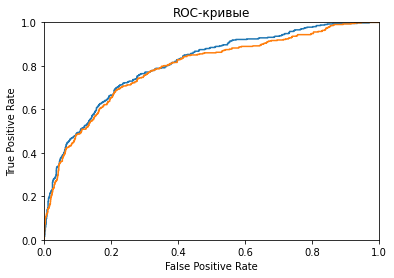

Метрики f1 для RFC-downsample: 0.524 для RFC-upsample: 0.547
Метрики auc_roc для RFC-downsample: 0.792 для RFC-upsample: 0.808


In [64]:
model_rfc_up = RandomForestClassifier().set_params(**best_rfc_params_up)
model_rfc_down = RandomForestClassifier().set_params(**best_rfc_params_down)
#model_dtc_down =  DecisionTreeClassifier.set_params(**best_dtc_params_down)

model_rfc_up.fit(data_x_upsampled, data_y_upsampled)
model_rfc_down.fit(data_x_upsampled, data_y_upsampled)
#model_dtc_down.fit(data_x_upsampled, data_y_upsampled)

rfc_predictions_up = model_rfc_up.predict(features_test)
rfc_predictions_down = model_rfc_down.predict(features_test)
#dtc_predictions_down = model_dtc_down.predict(features_test)

rfc_f1_up = f1_score(target_test, rfc_predictions_up)
rfc_f1_down = f1_score(target_test, rfc_predictions_down)
#dtc_f1_down = f1_score(target_test, dtc_predictions_down)

rfc_probabilities_up = model_rfc_up.predict_proba(features_test)
rfc_probabilities_one_up = rfc_probabilities_up[:, 1]
auc_roc_rfc_up = roc_auc_score(target_test, rfc_probabilities_one_up)
rfc_fpr_up, rfc_tpr_up, rfc_thresholds_up = roc_curve(target_test, rfc_probabilities_one_up)

rfc_probabilities_down = model_rfc_down.predict_proba(features_test)
rfc_probabilities_one_down = rfc_probabilities_down[:, 1]
auc_roc_rfc_down = roc_auc_score(target_test, rfc_probabilities_one_down)
rfc_fpr_down, rfc_tpr_down, rfc_thresholds_down = roc_curve(target_test, rfc_probabilities_one_down)


plt.figure()
plt.plot(rfc_fpr_up, rfc_tpr_up)
plt.plot(rfc_fpr_down, rfc_tpr_down)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.show() 

print('Метрики f1 для RFC-downsample:', round(rfc_f1_down, 3), 'для RFC-upsample:',  round(rfc_f1_up, 3))
print('Метрики auc_roc для RFC-downsample:', round(auc_roc_rfc_down, 3), 'для RFC-upsample:', round(auc_roc_rfc_up, 3))

Наилучшие значения метрик классификатора "Cлучайный лес" на тестовой выборке удалось достичь на увеличении объеденённой выборки. Значения параметров: **f1 = 0.638; AUC-ROC = 0.866**.

## Общий вывод
* Произведена предобработка данных.
* Числовые признаки приведены к стандартному виду (среднее = 0, стандартное отклонение = 1). 
* Категориальные признаки преобразованы методом One-Hot Encoder.
* Целевой признак распределён в сооотношении примерно 4:1.
* Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно
* Обучены модели "Решающее Дерево", "Случайный лес", "Dummy" c использованием GridSearchCV. 
* Проведён анализ моделей с кросс-валидацией без учёта дисбаланса классов. Ни в одной из модей не было достигнуто пороговое значение f1.
* **Upsampling-downsampling** обучающей выборки дали необходимый прирост точности и для моделей Случайный лес (**до соответственно 0.641 и 0.628**).
* Значение метрики f1 классификатора "Cлучайный лес" на тестовой выборке при увеличении обучающей выборки: **f1 = 0.638 и AUC-ROC = 0.866**; при уменьшении: **f1 = 0.609 и AUC-ROC = 0.863**. Построены в сравнении кривые ROC для моделей **RFC**, обученных на сокращенной и увевеличенной выборках.